# Why and When Attention Matters in Reinforcement Learning
> "Using RLlib and AttentionNet to master environments with stateless observations, here, stateless CartPole."

- hide: true
- toc: true
- branch: master
- badges: true
- comments: true
- categories: [python, gym, ray, rllib, tensorflow, machine learning, reinforcement learning, sequence, attention]
- image: images/cartpole.jpg

In reinforcement learning (RL), the RL agent typically selects a suitable action based on the last observation.
In many practical environments, the full state can only be observed partially,
such that important information may be missing when just considering the last observation.
This blog post covers options for dealing with missing and only partially observed state,
e.g., considering a *sequence* of last observations and applying *self-attention* to this sequence.


## Example: The CartPole Gym Environment

As an example, consider the popular [OpenAI Gym CartPole environment](https://gym.openai.com/envs/CartPole-v1/).
Here, the task is to move a cart left or right in order to balance a pole on the cart as long as possible.

![OpenAI Gym CartPole-v1 Environment](attention/cartpole.gif "OpenAI Gym CartPole-v1 Environment")

In the normal [`CartPole-v1` environment](https://gym.openai.com/envs/CartPole-v1/), the RL agent observes four scalar values ([defined here](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py#L26:L32)):
* The cart position, i.e., where the cart currently is.
* The cart velocity, i.e., how fast the cart is currently moving and in which direction (can be positive or negative).
* The pole angle, i.e., how tilted the pole currently is and in which direction.
* The pole angular velocity, i.e., how fast the pole is currently moving and in which direction.

All four observations are important to decide whether the cart should move left or right.

Now, assume the RL agent only has access to an instant snapshot of the cart and the pole (e.g., through a photo/raw pixels)
and can neither observe cart velocity nor pole angular velocity.
In this case, the RL agent does not know whether the pole is currently swinging to one side and cannot properly balance the pole.
How to deal with this problem of missing state (here, cart and pole velocity)?


## Options for Dealing With Missing State

There are different options for dealing with missing state, e.g., missing velocity in the CartPole example:

1. Add the missing state explicitly, e.g., measure and observe velocity. Note that this may require installing extra sensors or may even be infeasible in some scenarios.
2. Ignore the missing state, i.e., just rely on the available, partial observations. Depending on the missing state, this may be problematic and keep the agent from learning.
3. Keep track of a sequence of the last observations. By observing the cart position and pole angle over time, the agent can implicitly derive their velocity. There are different ways to deal with this sequence:
   1. Just use the sequence as is for a standard multi-layer perceptron (MLP)/dense feedforward neural network.
   2. Feed the sequence into a recurrent neural network (RNN), e.g., with long short-term memory (LSTM).
   3. Feed the sequence into a neural network with *self-attention*.

In the following, I explain each option in more detail and illustrate them using simple example code.


### Setup

For the examples, I use a PPO RL agent from Ray RLlib with the CartPole environment, described above.

To install these dependencies, run the following code (tested with Python 3.8 on Windows):

In [32]:
#collapse-output
!pip install ray[rllib]==1.8.0
!pip install tensorflow==2.7.0
!pip install seaborn==0.11.2
!pip install gym==0.21.0
!pip install pyglet==1.5.21

Start up ray, load the default PPO config, and determine the number of training iterations,
which is the same for all options (for comparability).

In [33]:
import ray

# adjust num_cpus and num_gpus to your system
# for some reason, num_cpus=2 gets stuck on my system (when trying to train)
ray.init(num_cpus=3, ignore_reinit_error=True)

# stop conditions based on training iterations (each with 4000 train steps)
stop = {"training_iteration": 10}

2021-11-23 19:46:59,351	INFO worker.py:832 -- Calling ray.init() again after it has already been called.


### Option 1: Explicitly Add Missing State

Sometimes, it is possible to extend the observations and explicitly add important state that was previously unobserved.
In the CartPole example, the cart and pole velocity can simply be "added" by using the default `CartPole-v1` environment.
Here, the cart velocity and pole velocity are already included in the observations.

Note that in many practical scenarios such "missing" state cannot be added and observed simply.
Instead, it may require installing additional sensors or may even be completely infeasible.

Let's start with the best case, i.e., explicitly including the missing state.

In [34]:
import gym

# the default CartPole env has all 4 observations: position and velocity of both cart and pole
env = gym.make("CartPole-v1")
env.observation_space.shape

(4,)

In [35]:
#collapse-output

from ray.rllib.agents import ppo

# run PPO on the default CartPole-v1 env
config1 = ppo.DEFAULT_CONFIG.copy()
config1["env"] = "CartPole-v1"

# training takes a while
results1 = ray.tune.run("PPO", config=config1, stop=stop)
print("Option 1: Training finished successfully")

Trial name,status,loc
PPO_CartPole-v1_bd6e2_00000,PENDING,


(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)


Trial name,status,loc
PPO_CartPole-v1_bd6e2_00000,PENDING,


(pid=9332) 2021-11-23 19:47:10,868	INFO trainer.py:753 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=9332) 2021-11-23 19:47:10,868	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(pid=9332) 2021-11-23 19:47:10,868	INFO trainer.py:770 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=6508) 2021-11-23 19:47:22,968	WARNING deprecation.py:38 -- Deprecatio

Trial name,status,loc
PPO_CartPole-v1_bd6e2_00000,RUNNING,127.0.0.1:9332


(pid=9332) 2021-11-23 19:47:25,401	WARNING trainer_template.py:185 -- `execution_plan` functions should accept `trainer`, `workers`, and `config` as args!
(pid=9332) 2021-11-23 19:47:25,401	INFO trainable.py:110 -- Trainable.setup took 14.534 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(pid=9332) 2021-11-23 19:47:25,401	WARNING util.py:57 -- Install gputil for GPU system monitoring.


Trial name,status,loc
PPO_CartPole-v1_bd6e2_00000,RUNNING,127.0.0.1:9332


(pid=9332) 2021-11-23 19:47:29,301	WARNING deprecation.py:38 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!


Trial name,status,loc
PPO_CartPole-v1_bd6e2_00000,RUNNING,127.0.0.1:9332


Result for PPO_CartPole-v1_bd6e2_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2021-11-23_19-47-32
  done: false
  episode_len_mean: 23.201183431952664
  episode_media: {}
  episode_reward_max: 64.0
  episode_reward_mean: 23.201183431952664
  episode_reward_min: 8.0
  episodes_this_iter: 169
  episodes_total: 169
  experiment_id: ada6434c43d44cc4854441944ca25a66
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.6663767099380493
          entropy_coeff: 0.0
          kl: 0.02739105187356472
          model: {}
          policy_loss: -0.04134032875299454
          total_loss: 200.2156219482422
          vf_explained_var: 0.026224354282021523
          vf_loss: 200.25149536132812
    num_agent_steps_sampled: 4000
    num_agent_steps_trained: 4000
    num_steps_sampled: 4000
    num_steps_trained: 4000


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_CartPole-v1_bd6e2_00000,RUNNING,127.0.0.1:9332,1,7.51691,4000,23.2012,64,8,23.2012


Result for PPO_CartPole-v1_bd6e2_00000:
  agent_timesteps_total: 8000
  custom_metrics: {}
  date: 2021-11-23_19-47-39
  done: false
  episode_len_mean: 42.95
  episode_media: {}
  episode_reward_max: 150.0
  episode_reward_mean: 42.95
  episode_reward_min: 10.0
  episodes_this_iter: 87
  episodes_total: 256
  experiment_id: ada6434c43d44cc4854441944ca25a66
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.30000001192092896
          cur_lr: 4.999999873689376e-05
          entropy: 0.6131702065467834
          entropy_coeff: 0.0
          kl: 0.015614509582519531
          model: {}
          policy_loss: -0.030681779608130455
          total_loss: 312.3175964355469
          vf_explained_var: 0.07965515553951263
          vf_loss: 312.3436279296875
    num_agent_steps_sampled: 8000
    num_agent_steps_trained: 8000
    num_steps_sampled: 8000
    num_steps_trained: 8000
    num_steps_trained_thi

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_CartPole-v1_bd6e2_00000,RUNNING,127.0.0.1:9332,2,14.3835,8000,42.95,150,10,42.95


Result for PPO_CartPole-v1_bd6e2_00000:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2021-11-23_19-47-46
  done: false
  episode_len_mean: 72.01
  episode_media: {}
  episode_reward_max: 367.0
  episode_reward_mean: 72.01
  episode_reward_min: 10.0
  episodes_this_iter: 31
  episodes_total: 287
  experiment_id: ada6434c43d44cc4854441944ca25a66
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.30000001192092896
          cur_lr: 4.999999873689376e-05
          entropy: 0.5750772953033447
          entropy_coeff: 0.0
          kl: 0.010552152059972286
          model: {}
          policy_loss: -0.02355009876191616
          total_loss: 682.247802734375
          vf_explained_var: 0.08913025259971619
          vf_loss: 682.2681274414062
    num_agent_steps_sampled: 12000
    num_agent_steps_trained: 12000
    num_steps_sampled: 12000
    num_steps_trained: 12000
    num_steps_trained_

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_CartPole-v1_bd6e2_00000,RUNNING,127.0.0.1:9332,3,20.9668,12000,72.01,367,10,72.01


Result for PPO_CartPole-v1_bd6e2_00000:
  agent_timesteps_total: 16000
  custom_metrics: {}
  date: 2021-11-23_19-47-53
  done: false
  episode_len_mean: 99.53
  episode_media: {}
  episode_reward_max: 367.0
  episode_reward_mean: 99.53
  episode_reward_min: 10.0
  episodes_this_iter: 24
  episodes_total: 311
  experiment_id: ada6434c43d44cc4854441944ca25a66
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.30000001192092896
          cur_lr: 4.999999873689376e-05
          entropy: 0.5543258190155029
          entropy_coeff: 0.0
          kl: 0.005451680161058903
          model: {}
          policy_loss: -0.013567883521318436
          total_loss: 657.56103515625
          vf_explained_var: 0.31792160868644714
          vf_loss: 657.572998046875
    num_agent_steps_sampled: 16000
    num_agent_steps_trained: 16000
    num_steps_sampled: 16000
    num_steps_trained: 16000
    num_steps_trained_t

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_CartPole-v1_bd6e2_00000,RUNNING,127.0.0.1:9332,4,27.6669,16000,99.53,367,10,99.53


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_CartPole-v1_bd6e2_00000,RUNNING,127.0.0.1:9332,4,27.6669,16000,99.53,367,10,99.53


Result for PPO_CartPole-v1_bd6e2_00000:
  agent_timesteps_total: 20000
  custom_metrics: {}
  date: 2021-11-23_19-47-59
  done: false
  episode_len_mean: 131.85
  episode_media: {}
  episode_reward_max: 472.0
  episode_reward_mean: 131.85
  episode_reward_min: 11.0
  episodes_this_iter: 16
  episodes_total: 327
  experiment_id: ada6434c43d44cc4854441944ca25a66
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.30000001192092896
          cur_lr: 4.999999873689376e-05
          entropy: 0.5512375831604004
          entropy_coeff: 0.0
          kl: 0.0024686120450496674
          model: {}
          policy_loss: -0.010818097740411758
          total_loss: 538.4854125976562
          vf_explained_var: 0.321399986743927
          vf_loss: 538.4955444335938
    num_agent_steps_sampled: 20000
    num_agent_steps_trained: 20000
    num_steps_sampled: 20000
    num_steps_trained: 20000
    num_steps_train

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_CartPole-v1_bd6e2_00000,RUNNING,127.0.0.1:9332,5,34.2836,20000,131.85,472,11,131.85


Result for PPO_CartPole-v1_bd6e2_00000:
  agent_timesteps_total: 24000
  custom_metrics: {}
  date: 2021-11-23_19-48-06
  done: false
  episode_len_mean: 165.3
  episode_media: {}
  episode_reward_max: 500.0
  episode_reward_mean: 165.3
  episode_reward_min: 14.0
  episodes_this_iter: 14
  episodes_total: 341
  experiment_id: ada6434c43d44cc4854441944ca25a66
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.15000000596046448
          cur_lr: 4.999999873689376e-05
          entropy: 0.5289359092712402
          entropy_coeff: 0.0
          kl: 0.007540307007730007
          model: {}
          policy_loss: -0.010302959010004997
          total_loss: 430.6041564941406
          vf_explained_var: 0.3625507056713104
          vf_loss: 430.6133117675781
    num_agent_steps_sampled: 24000
    num_agent_steps_trained: 24000
    num_steps_sampled: 24000
    num_steps_trained: 24000
    num_steps_trained

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_CartPole-v1_bd6e2_00000,RUNNING,127.0.0.1:9332,6,40.8671,24000,165.3,500,14,165.3


Result for PPO_CartPole-v1_bd6e2_00000:
  agent_timesteps_total: 28000
  custom_metrics: {}
  date: 2021-11-23_19-48-13
  done: false
  episode_len_mean: 200.73
  episode_media: {}
  episode_reward_max: 500.0
  episode_reward_mean: 200.73
  episode_reward_min: 14.0
  episodes_this_iter: 10
  episodes_total: 351
  experiment_id: ada6434c43d44cc4854441944ca25a66
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.15000000596046448
          cur_lr: 4.999999873689376e-05
          entropy: 0.5529451966285706
          entropy_coeff: 0.0
          kl: 0.004082479979842901
          model: {}
          policy_loss: -0.007522972766309977
          total_loss: 385.4500427246094
          vf_explained_var: 0.34760990738868713
          vf_loss: 385.45697021484375
    num_agent_steps_sampled: 28000
    num_agent_steps_trained: 28000
    num_steps_sampled: 28000
    num_steps_trained: 28000
    num_steps_tra

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_CartPole-v1_bd6e2_00000,RUNNING,127.0.0.1:9332,7,47.6834,28000,200.73,500,14,200.73


Result for PPO_CartPole-v1_bd6e2_00000:
  agent_timesteps_total: 32000
  custom_metrics: {}
  date: 2021-11-23_19-48-20
  done: false
  episode_len_mean: 231.96
  episode_media: {}
  episode_reward_max: 500.0
  episode_reward_mean: 231.96
  episode_reward_min: 22.0
  episodes_this_iter: 8
  episodes_total: 359
  experiment_id: ada6434c43d44cc4854441944ca25a66
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.07500000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.5215219259262085
          entropy_coeff: 0.0
          kl: 0.003867241321131587
          model: {}
          policy_loss: -0.006445886567234993
          total_loss: 463.6306457519531
          vf_explained_var: 0.039233140647411346
          vf_loss: 463.6368408203125
    num_agent_steps_sampled: 32000
    num_agent_steps_trained: 32000
    num_steps_sampled: 32000
    num_steps_trained: 32000
    num_steps_trai

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_CartPole-v1_bd6e2_00000,RUNNING,127.0.0.1:9332,8,54.4999,32000,231.96,500,22,231.96


Result for PPO_CartPole-v1_bd6e2_00000:
  agent_timesteps_total: 36000
  custom_metrics: {}
  date: 2021-11-23_19-48-26
  done: false
  episode_len_mean: 262.68
  episode_media: {}
  episode_reward_max: 500.0
  episode_reward_mean: 262.68
  episode_reward_min: 23.0
  episodes_this_iter: 9
  episodes_total: 368
  experiment_id: ada6434c43d44cc4854441944ca25a66
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.03750000149011612
          cur_lr: 4.999999873689376e-05
          entropy: 0.5338630676269531
          entropy_coeff: 0.0
          kl: 0.007856571115553379
          model: {}
          policy_loss: -0.023872433230280876
          total_loss: 322.21954345703125
          vf_explained_var: 0.245315819978714
          vf_loss: 322.2431335449219
    num_agent_steps_sampled: 36000
    num_agent_steps_trained: 36000
    num_steps_sampled: 36000
    num_steps_trained: 36000
    num_steps_traine

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_CartPole-v1_bd6e2_00000,RUNNING,127.0.0.1:9332,9,61.2168,36000,262.68,500,23,262.68


Result for PPO_CartPole-v1_bd6e2_00000:
  agent_timesteps_total: 40000
  custom_metrics: {}
  date: 2021-11-23_19-48-33
  done: true
  episode_len_mean: 293.67
  episode_media: {}
  episode_reward_max: 500.0
  episode_reward_mean: 293.67
  episode_reward_min: 23.0
  episodes_this_iter: 8
  episodes_total: 376
  experiment_id: ada6434c43d44cc4854441944ca25a66
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.03750000149011612
          cur_lr: 4.999999873689376e-05
          entropy: 0.5301569700241089
          entropy_coeff: 0.0
          kl: 0.003627386409789324
          model: {}
          policy_loss: -0.014947282150387764
          total_loss: 501.4374694824219
          vf_explained_var: -0.0290857944637537
          vf_loss: 501.4522705078125
    num_agent_steps_sampled: 40000
    num_agent_steps_trained: 40000
    num_steps_sampled: 40000
    num_steps_trained: 40000
    num_steps_traine

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_CartPole-v1_bd6e2_00000,TERMINATED,127.0.0.1:9332,10,67.8499,40000,293.67,500,23,293.67


(pid=9332) [2021-11-23 19:48:34,182 E 9332 1660] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
(pid=9332) Windows fatal exception: access violation
(pid=9332) 
(pid=5972) [2021-11-23 19:48:34,205 C 5972 17072] core_worker.cc:796:  Check failed: _s.ok() Bad status: IOError: Unknown error
(pid=5972) *** StackTrace Information ***
(pid=5972)     PyInit__raylet
(pid=5972)     PyInit__raylet
(pid=5972)     PyInit__raylet
(pid=5972)     PyInit__raylet
(pid=5972)     PyInit__raylet
(pid=5972)     PyInit__raylet
(pid=5972)     PyInit__raylet
(pid=5972)     PyInit__raylet
(pid=5972)     PyInit__raylet
(pid=5972)     PyInit__raylet
(pid=5972)     PyInit__raylet
(pid=5972)     PyInit__raylet
(pid=5972)     PyInit__raylet
(pid=5972)     PyInit__raylet
(pid=5972)     PyInit__raylet
(pid=5972)     PyInit__raylet
(pid=5972)     PyNumber_InPlaceLshift
(pid=5972)     Py_CheckFunctionResult
(pid=5972)     PyEval_EvalFrameDefault
(pid=5972)     Py_CheckFunc

Option 1: Training finished successfully


In [36]:
# check results
results1.default_metric = "episode_reward_mean"
results1.default_mode = "max"
# print mean number of time steps the pole was balanced (higher = better)
results1.best_result["episode_reward_mean"]

293.67

c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


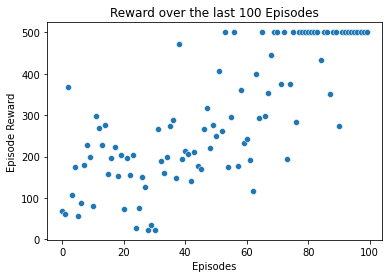

In [37]:
# plot the last 100 episode rewards
import seaborn as sns

def plot_rewards(results):
    """Plot scatter plot of the last 100 training episodes"""
    eps_rewards = results.best_result["hist_stats"]["episode_reward"]
    eps = [i for i in range(len(eps_rewards))]
    ax = sns.scatterplot(eps, eps_rewards)
    ax.set_title("Reward over the last 100 Episodes")
    ax.set_xlabel("Episodes")
    ax.set_ylabel("Episode Reward")


plot_rewards(results1)


## Option 2: Ignore Missing State

In many practical

In [38]:
from ray.rllib.examples.env.stateless_cartpole import StatelessCartPole
from ray.tune import registry

registry.register_env("StatelessCartPole", lambda _: StatelessCartPole())
config2 = ppo.DEFAULT_CONFIG.copy()
config2["env"] = "StatelessCartPole"
# train; this takes a while
results2 = ray.tune.run("PPO", config=config2, stop=stop)
print("Option 2: Training finished successfully")

Trial name,status,loc
PPO_StatelessCartPole_f6243_00000,PENDING,


(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)


Trial name,status,loc
PPO_StatelessCartPole_f6243_00000,PENDING,


(pid=15776) 2021-11-23 19:48:45,935	INFO trainer.py:753 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=15776) 2021-11-23 19:48:45,935	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(pid=15776) 2021-11-23 19:48:45,935	INFO trainer.py:770 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=24480) 2021-11-23 19:48:59,018	WARNING deprecation.py:38 -- Deprec

Trial name,status,loc
PPO_StatelessCartPole_f6243_00000,RUNNING,127.0.0.1:15776


(pid=15776) 2021-11-23 19:49:01,452	WARNING trainer_template.py:185 -- `execution_plan` functions should accept `trainer`, `workers`, and `config` as args!
(pid=15776) 2021-11-23 19:49:01,452	INFO trainable.py:110 -- Trainable.setup took 15.517 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(pid=15776) 2021-11-23 19:49:01,468	WARNING util.py:57 -- Install gputil for GPU system monitoring.


Trial name,status,loc
PPO_StatelessCartPole_f6243_00000,RUNNING,127.0.0.1:15776


(pid=15776) 2021-11-23 19:49:05,068	WARNING deprecation.py:38 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!


Trial name,status,loc
PPO_StatelessCartPole_f6243_00000,RUNNING,127.0.0.1:15776


Result for PPO_StatelessCartPole_f6243_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2021-11-23_19-49-08
  done: false
  episode_len_mean: 20.723958333333332
  episode_media: {}
  episode_reward_max: 64.0
  episode_reward_mean: 20.723958333333332
  episode_reward_min: 9.0
  episodes_this_iter: 192
  episodes_total: 192
  experiment_id: e1ee612c6c3f4f48a9f19984a409dc5c
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.6812710165977478
          entropy_coeff: 0.0
          kl: 0.012129432521760464
          model: {}
          policy_loss: -0.019796958193182945
          total_loss: 149.3815155029297
          vf_explained_var: 0.007414208725094795
          vf_loss: 149.39889526367188
    num_agent_steps_sampled: 4000
    num_agent_steps_trained: 4000
    num_steps_sampled: 4000
    num_steps_traine

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_f6243_00000,RUNNING,127.0.0.1:15776,1,7.17222,4000,20.724,64,9,20.724


Result for PPO_StatelessCartPole_f6243_00000:
  agent_timesteps_total: 8000
  custom_metrics: {}
  date: 2021-11-23_19-49-15
  done: false
  episode_len_mean: 27.685314685314687
  episode_media: {}
  episode_reward_max: 77.0
  episode_reward_mean: 27.685314685314687
  episode_reward_min: 10.0
  episodes_this_iter: 143
  episodes_total: 335
  experiment_id: e1ee612c6c3f4f48a9f19984a409dc5c
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.6397432684898376
          entropy_coeff: 0.0
          kl: 0.014385893940925598
          model: {}
          policy_loss: -0.024019667878746986
          total_loss: 124.4566650390625
          vf_explained_var: 0.03795936703681946
          vf_loss: 124.4778060913086
    num_agent_steps_sampled: 8000
    num_agent_steps_trained: 8000
    num_steps_sampled: 8000
    num_steps_trained

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_f6243_00000,RUNNING,127.0.0.1:15776,2,13.9219,8000,27.6853,77,10,27.6853


Result for PPO_StatelessCartPole_f6243_00000:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2021-11-23_19-49-22
  done: false
  episode_len_mean: 41.26
  episode_media: {}
  episode_reward_max: 130.0
  episode_reward_mean: 41.26
  episode_reward_min: 10.0
  episodes_this_iter: 96
  episodes_total: 431
  experiment_id: e1ee612c6c3f4f48a9f19984a409dc5c
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.6044858694076538
          entropy_coeff: 0.0
          kl: 0.006583377253264189
          model: {}
          policy_loss: -0.010080553591251373
          total_loss: 215.9619140625
          vf_explained_var: 0.08694871515035629
          vf_loss: 215.97067260742188
    num_agent_steps_sampled: 12000
    num_agent_steps_trained: 12000
    num_steps_sampled: 12000
    num_steps_trained: 12000
    num_steps_tr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_f6243_00000,RUNNING,127.0.0.1:15776,3,20.6714,12000,41.26,130,10,41.26


Result for PPO_StatelessCartPole_f6243_00000:
  agent_timesteps_total: 16000
  custom_metrics: {}
  date: 2021-11-23_19-49-29
  done: false
  episode_len_mean: 43.61
  episode_media: {}
  episode_reward_max: 155.0
  episode_reward_mean: 43.61
  episode_reward_min: 11.0
  episodes_this_iter: 90
  episodes_total: 521
  experiment_id: e1ee612c6c3f4f48a9f19984a409dc5c
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.5590699315071106
          entropy_coeff: 0.0
          kl: 0.004985678941011429
          model: {}
          policy_loss: -0.00941834133118391
          total_loss: 248.4127655029297
          vf_explained_var: 0.12295760214328766
          vf_loss: 248.42120361328125
    num_agent_steps_sampled: 16000
    num_agent_steps_trained: 16000
    num_steps_sampled: 16000
    num_steps_trained: 16000
    num_steps_

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_f6243_00000,RUNNING,127.0.0.1:15776,4,27.4045,16000,43.61,155,11,43.61


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_f6243_00000,RUNNING,127.0.0.1:15776,4,27.4045,16000,43.61,155,11,43.61


Result for PPO_StatelessCartPole_f6243_00000:
  agent_timesteps_total: 20000
  custom_metrics: {}
  date: 2021-11-23_19-49-36
  done: false
  episode_len_mean: 45.82
  episode_media: {}
  episode_reward_max: 155.0
  episode_reward_mean: 45.82
  episode_reward_min: 12.0
  episodes_this_iter: 89
  episodes_total: 610
  experiment_id: e1ee612c6c3f4f48a9f19984a409dc5c
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.10000000149011612
          cur_lr: 4.999999873689376e-05
          entropy: 0.5189774036407471
          entropy_coeff: 0.0
          kl: 0.003044182201847434
          model: {}
          policy_loss: 0.001426202361471951
          total_loss: 230.5676727294922
          vf_explained_var: 0.16542400419712067
          vf_loss: 230.5659637451172
    num_agent_steps_sampled: 20000
    num_agent_steps_trained: 20000
    num_steps_sampled: 20000
    num_steps_trained: 20000
    num_steps_t

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_f6243_00000,RUNNING,127.0.0.1:15776,5,35.088,20000,45.82,155,12,45.82


Result for PPO_StatelessCartPole_f6243_00000:
  agent_timesteps_total: 24000
  custom_metrics: {}
  date: 2021-11-23_19-49-44
  done: false
  episode_len_mean: 47.12
  episode_media: {}
  episode_reward_max: 123.0
  episode_reward_mean: 47.12
  episode_reward_min: 11.0
  episodes_this_iter: 86
  episodes_total: 696
  experiment_id: e1ee612c6c3f4f48a9f19984a409dc5c
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.05000000074505806
          cur_lr: 4.999999873689376e-05
          entropy: 0.4841262400150299
          entropy_coeff: 0.0
          kl: 0.002589465817436576
          model: {}
          policy_loss: -0.0048765153624117374
          total_loss: 186.0424041748047
          vf_explained_var: 0.18889868259429932
          vf_loss: 186.0471649169922
    num_agent_steps_sampled: 24000
    num_agent_steps_trained: 24000
    num_steps_sampled: 24000
    num_steps_trained: 24000
    num_steps

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_f6243_00000,RUNNING,127.0.0.1:15776,6,43.0393,24000,47.12,123,11,47.12


Result for PPO_StatelessCartPole_f6243_00000:
  agent_timesteps_total: 28000
  custom_metrics: {}
  date: 2021-11-23_19-49-52
  done: false
  episode_len_mean: 48.9
  episode_media: {}
  episode_reward_max: 132.0
  episode_reward_mean: 48.9
  episode_reward_min: 10.0
  episodes_this_iter: 78
  episodes_total: 774
  experiment_id: e1ee612c6c3f4f48a9f19984a409dc5c
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.02500000037252903
          cur_lr: 4.999999873689376e-05
          entropy: 0.4601098895072937
          entropy_coeff: 0.0
          kl: 0.0032913885079324245
          model: {}
          policy_loss: -0.009747156873345375
          total_loss: 165.0985107421875
          vf_explained_var: 0.2212902456521988
          vf_loss: 165.10816955566406
    num_agent_steps_sampled: 28000
    num_agent_steps_trained: 28000
    num_steps_sampled: 28000
    num_steps_trained: 28000
    num_steps_t

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_f6243_00000,RUNNING,127.0.0.1:15776,7,50.7223,28000,48.9,132,10,48.9


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_f6243_00000,RUNNING,127.0.0.1:15776,7,50.7223,28000,48.9,132,10,48.9


Result for PPO_StatelessCartPole_f6243_00000:
  agent_timesteps_total: 32000
  custom_metrics: {}
  date: 2021-11-23_19-50-00
  done: false
  episode_len_mean: 49.94
  episode_media: {}
  episode_reward_max: 132.0
  episode_reward_mean: 49.94
  episode_reward_min: 10.0
  episodes_this_iter: 80
  episodes_total: 854
  experiment_id: e1ee612c6c3f4f48a9f19984a409dc5c
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.012500000186264515
          cur_lr: 4.999999873689376e-05
          entropy: 0.41464871168136597
          entropy_coeff: 0.0
          kl: 0.003240640740841627
          model: {}
          policy_loss: -0.0035140279214829206
          total_loss: 157.30711364746094
          vf_explained_var: 0.2239331603050232
          vf_loss: 157.31057739257812
    num_agent_steps_sampled: 32000
    num_agent_steps_trained: 32000
    num_steps_sampled: 32000
    num_steps_trained: 32000
    num_st

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_f6243_00000,RUNNING,127.0.0.1:15776,8,58.3996,32000,49.94,132,10,49.94


Result for PPO_StatelessCartPole_f6243_00000:
  agent_timesteps_total: 36000
  custom_metrics: {}
  date: 2021-11-23_19-50-08
  done: false
  episode_len_mean: 51.12
  episode_media: {}
  episode_reward_max: 125.0
  episode_reward_mean: 51.12
  episode_reward_min: 14.0
  episodes_this_iter: 79
  episodes_total: 933
  experiment_id: e1ee612c6c3f4f48a9f19984a409dc5c
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0062500000931322575
          cur_lr: 4.999999873689376e-05
          entropy: 0.43995144963264465
          entropy_coeff: 0.0
          kl: 0.002562695648521185
          model: {}
          policy_loss: -0.008500334806740284
          total_loss: 144.52923583984375
          vf_explained_var: 0.27317333221435547
          vf_loss: 144.5377197265625
    num_agent_steps_sampled: 36000
    num_agent_steps_trained: 36000
    num_steps_sampled: 36000
    num_steps_trained: 36000
    num_st

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_f6243_00000,RUNNING,127.0.0.1:15776,9,66.2166,36000,51.12,125,14,51.12


Result for PPO_StatelessCartPole_f6243_00000:
  agent_timesteps_total: 40000
  custom_metrics: {}
  date: 2021-11-23_19-50-16
  done: true
  episode_len_mean: 51.67
  episode_media: {}
  episode_reward_max: 147.0
  episode_reward_mean: 51.67
  episode_reward_min: 16.0
  episodes_this_iter: 74
  episodes_total: 1007
  experiment_id: e1ee612c6c3f4f48a9f19984a409dc5c
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0031250000465661287
          cur_lr: 4.999999873689376e-05
          entropy: 0.4446806311607361
          entropy_coeff: 0.0
          kl: 0.0022894737776368856
          model: {}
          policy_loss: 0.003023507073521614
          total_loss: 219.97442626953125
          vf_explained_var: 0.1855245977640152
          vf_loss: 219.9713897705078
    num_agent_steps_sampled: 40000
    num_agent_steps_trained: 40000
    num_steps_sampled: 40000
    num_steps_trained: 40000
    num_step

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_f6243_00000,TERMINATED,127.0.0.1:15776,10,74.1832,40000,51.67,147,16,51.67


(pid=15776) Windows fatal exception: access violation
(pid=15776) 
(pid=24480) [2021-11-23 19:50:16,710 E 24480 11408] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
(pid=16964) [2021-11-23 19:50:16,721 E 16964 23092] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
(pid=16964) Windows fatal exception: access violation
(pid=16964) 
2021-11-23 19:50:16,834	INFO tune.py:630 -- Total run time: 102.31 seconds (101.56 seconds for the tuning loop).


Option 2: Training finished successfully


In [39]:
# check results
results2.default_metric = "episode_reward_mean"
results2.default_mode = "max"
# print the mean episode reward = episode length --> higher = better
results2.best_result["episode_reward_mean"]

51.67

c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


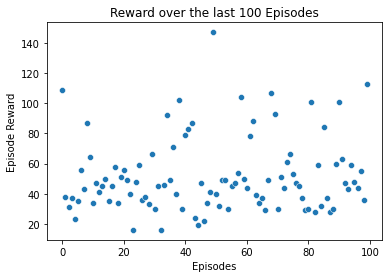

In [40]:
plot_rewards(results2)

## Option 3: Use Sequence of Last Observations

### Option 3a: Use Raw Sequence as Input

For an MLP; stack last 10 observations

Use Gym's `FrameStack` to automatically stack the last x frames.

In [41]:
from gym.wrappers import FrameStack

# stateless CartPole --> only 2 observations: position of cart & angle of pole (not: velocity of cart or pole)
env = StatelessCartPole()
print(f"Shape of observation space (stateless CartPole): {env.observation_space.shape}")

# stack last 10 observations into sequence --> 10x2
env_stacked = FrameStack(env, 10)
print(f"Shape of observation space (stacked stateless CartPole): {env_stacked.observation_space.shape}")

# register env for RLlib
registry.register_env("StackedStatelessCartPole", lambda _: FrameStack(StatelessCartPole(), 10))

Shape of observation space (stateless CartPole): (2,)
Shape of observation space (stacked stateless CartPole): (10, 2)


In [42]:
# use PPO with vanilla MLP
config3a = ppo.DEFAULT_CONFIG.copy()
config3a["env"] = "StackedStatelessCartPole"
# train; this takes a while
results3a = ray.tune.run("PPO", config=config3a, stop=stop)
print("Option 3a: Training finished successfully")

Trial name,status,loc
PPO_StackedStatelessCartPole_334c6_00000,PENDING,


(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)


Trial name,status,loc
PPO_StackedStatelessCartPole_334c6_00000,PENDING,


(pid=21856) 2021-11-23 19:50:30,258	INFO trainer.py:753 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=21856) 2021-11-23 19:50:30,258	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(pid=21856) 2021-11-23 19:50:30,258	INFO trainer.py:770 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=2944) c:\users\stefan\git-repos\private\blog\venv\lib\site-package

Trial name,status,loc
PPO_StackedStatelessCartPole_334c6_00000,RUNNING,127.0.0.1:21856


(pid=21856) 2021-11-23 19:50:46,918	WARNING trainer_template.py:185 -- `execution_plan` functions should accept `trainer`, `workers`, and `config` as args!
(pid=21856) 2021-11-23 19:50:46,918	INFO trainable.py:110 -- Trainable.setup took 16.666 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(pid=21856) 2021-11-23 19:50:46,934	WARNING util.py:57 -- Install gputil for GPU system monitoring.


Trial name,status,loc
PPO_StackedStatelessCartPole_334c6_00000,RUNNING,127.0.0.1:21856


(pid=21856) 2021-11-23 19:50:52,286	WARNING deprecation.py:38 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!


Trial name,status,loc
PPO_StackedStatelessCartPole_334c6_00000,RUNNING,127.0.0.1:21856


Result for PPO_StackedStatelessCartPole_334c6_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2021-11-23_19-50-57
  done: false
  episode_len_mean: 21.583783783783783
  episode_media: {}
  episode_reward_max: 71.0
  episode_reward_mean: 21.583783783783783
  episode_reward_min: 9.0
  episodes_this_iter: 185
  episodes_total: 185
  experiment_id: 3406233b9d5e48b6850f434e85f011e6
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.6828362345695496
          entropy_coeff: 0.0
          kl: 0.01051727682352066
          model: {}
          policy_loss: -0.013245193287730217
          total_loss: 173.20103454589844
          vf_explained_var: 0.009739658795297146
          vf_loss: 173.212158203125
    num_agent_steps_sampled: 4000
    num_agent_steps_trained: 4000
    num_steps_sampled: 4000
    num_steps_t

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StackedStatelessCartPole_334c6_00000,RUNNING,127.0.0.1:21856,1,10.328,4000,21.5838,71,9,21.5838


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StackedStatelessCartPole_334c6_00000,RUNNING,127.0.0.1:21856,1,10.328,4000,21.5838,71,9,21.5838


Result for PPO_StackedStatelessCartPole_334c6_00000:
  agent_timesteps_total: 8000
  custom_metrics: {}
  date: 2021-11-23_19-51-05
  done: false
  episode_len_mean: 28.392857142857142
  episode_media: {}
  episode_reward_max: 128.0
  episode_reward_mean: 28.392857142857142
  episode_reward_min: 10.0
  episodes_this_iter: 140
  episodes_total: 325
  experiment_id: 3406233b9d5e48b6850f434e85f011e6
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.6483438611030579
          entropy_coeff: 0.0
          kl: 0.011442010290920734
          model: {}
          policy_loss: -0.019726689904928207
          total_loss: 179.05523681640625
          vf_explained_var: 0.005053635686635971
          vf_loss: 179.0726776123047
    num_agent_steps_sampled: 8000
    num_agent_steps_trained: 8000
    num_steps_sampled: 8000
    num_ste

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StackedStatelessCartPole_334c6_00000,RUNNING,127.0.0.1:21856,2,18.6395,8000,28.3929,128,10,28.3929


Result for PPO_StackedStatelessCartPole_334c6_00000:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2021-11-23_19-51-13
  done: false
  episode_len_mean: 43.38
  episode_media: {}
  episode_reward_max: 149.0
  episode_reward_mean: 43.38
  episode_reward_min: 10.0
  episodes_this_iter: 89
  episodes_total: 414
  experiment_id: 3406233b9d5e48b6850f434e85f011e6
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.6209912896156311
          entropy_coeff: 0.0
          kl: 0.007972992956638336
          model: {}
          policy_loss: -0.019326912239193916
          total_loss: 285.2525634765625
          vf_explained_var: 0.026905234903097153
          vf_loss: 285.2702941894531
    num_agent_steps_sampled: 12000
    num_agent_steps_trained: 12000
    num_steps_sampled: 12000
    num_steps_trained: 12000
    nu

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StackedStatelessCartPole_334c6_00000,RUNNING,127.0.0.1:21856,3,26.0064,12000,43.38,149,10,43.38


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StackedStatelessCartPole_334c6_00000,RUNNING,127.0.0.1:21856,3,26.0064,12000,43.38,149,10,43.38


Result for PPO_StackedStatelessCartPole_334c6_00000:
  agent_timesteps_total: 16000
  custom_metrics: {}
  date: 2021-11-23_19-51-20
  done: false
  episode_len_mean: 54.51
  episode_media: {}
  episode_reward_max: 162.0
  episode_reward_mean: 54.51
  episode_reward_min: 10.0
  episodes_this_iter: 64
  episodes_total: 478
  experiment_id: 3406233b9d5e48b6850f434e85f011e6
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.5755634307861328
          entropy_coeff: 0.0
          kl: 0.007560615427792072
          model: {}
          policy_loss: -0.011042849160730839
          total_loss: 282.7450256347656
          vf_explained_var: 0.11883030086755753
          vf_loss: 282.7546081542969
    num_agent_steps_sampled: 16000
    num_agent_steps_trained: 16000
    num_steps_sampled: 16000
    num_steps_trained: 16000
    num

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StackedStatelessCartPole_334c6_00000,RUNNING,127.0.0.1:21856,4,33.5399,16000,54.51,162,10,54.51


Result for PPO_StackedStatelessCartPole_334c6_00000:
  agent_timesteps_total: 20000
  custom_metrics: {}
  date: 2021-11-23_19-51-27
  done: false
  episode_len_mean: 76.08
  episode_media: {}
  episode_reward_max: 224.0
  episode_reward_mean: 76.08
  episode_reward_min: 11.0
  episodes_this_iter: 40
  episodes_total: 518
  experiment_id: 3406233b9d5e48b6850f434e85f011e6
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.5578123927116394
          entropy_coeff: 0.0
          kl: 0.004904056433588266
          model: {}
          policy_loss: -0.009942948818206787
          total_loss: 460.74786376953125
          vf_explained_var: 0.20050150156021118
          vf_loss: 460.7568664550781
    num_agent_steps_sampled: 20000
    num_agent_steps_trained: 20000
    num_steps_sampled: 20000
    num_steps_trained: 20000
    nu

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StackedStatelessCartPole_334c6_00000,RUNNING,127.0.0.1:21856,5,40.4562,20000,76.08,224,11,76.08


Result for PPO_StackedStatelessCartPole_334c6_00000:
  agent_timesteps_total: 24000
  custom_metrics: {}
  date: 2021-11-23_19-51-34
  done: false
  episode_len_mean: 95.69
  episode_media: {}
  episode_reward_max: 292.0
  episode_reward_mean: 95.69
  episode_reward_min: 11.0
  episodes_this_iter: 31
  episodes_total: 549
  experiment_id: 3406233b9d5e48b6850f434e85f011e6
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.10000000149011612
          cur_lr: 4.999999873689376e-05
          entropy: 0.5465037822723389
          entropy_coeff: 0.0
          kl: 0.010195990093052387
          model: {}
          policy_loss: -0.015780465677380562
          total_loss: 540.371826171875
          vf_explained_var: 0.37211480736732483
          vf_loss: 540.3865356445312
    num_agent_steps_sampled: 24000
    num_agent_steps_trained: 24000
    num_steps_sampled: 24000
    num_steps_trained: 24000
    num_

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StackedStatelessCartPole_334c6_00000,RUNNING,127.0.0.1:21856,6,47.4063,24000,95.69,292,11,95.69


Result for PPO_StackedStatelessCartPole_334c6_00000:
  agent_timesteps_total: 28000
  custom_metrics: {}
  date: 2021-11-23_19-51-41
  done: false
  episode_len_mean: 119.4
  episode_media: {}
  episode_reward_max: 348.0
  episode_reward_mean: 119.4
  episode_reward_min: 11.0
  episodes_this_iter: 29
  episodes_total: 578
  experiment_id: 3406233b9d5e48b6850f434e85f011e6
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.10000000149011612
          cur_lr: 4.999999873689376e-05
          entropy: 0.5417383313179016
          entropy_coeff: 0.0
          kl: 0.014021089300513268
          model: {}
          policy_loss: -0.01545604970306158
          total_loss: 454.87908935546875
          vf_explained_var: 0.30136990547180176
          vf_loss: 454.8931579589844
    num_agent_steps_sampled: 28000
    num_agent_steps_trained: 28000
    num_steps_sampled: 28000
    num_steps_trained: 28000
    num

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StackedStatelessCartPole_334c6_00000,RUNNING,127.0.0.1:21856,7,54.3397,28000,119.4,348,11,119.4


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StackedStatelessCartPole_334c6_00000,RUNNING,127.0.0.1:21856,7,54.3397,28000,119.4,348,11,119.4


Result for PPO_StackedStatelessCartPole_334c6_00000:
  agent_timesteps_total: 32000
  custom_metrics: {}
  date: 2021-11-23_19-51-48
  done: false
  episode_len_mean: 144.95
  episode_media: {}
  episode_reward_max: 428.0
  episode_reward_mean: 144.95
  episode_reward_min: 13.0
  episodes_this_iter: 17
  episodes_total: 595
  experiment_id: 3406233b9d5e48b6850f434e85f011e6
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.10000000149011612
          cur_lr: 4.999999873689376e-05
          entropy: 0.5297797918319702
          entropy_coeff: 0.0
          kl: 0.006123337894678116
          model: {}
          policy_loss: -0.008807317353785038
          total_loss: 491.5013427734375
          vf_explained_var: 0.3308054804801941
          vf_loss: 491.5095520019531
    num_agent_steps_sampled: 32000
    num_agent_steps_trained: 32000
    num_steps_sampled: 32000
    num_steps_trained: 32000
    nu

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StackedStatelessCartPole_334c6_00000,RUNNING,127.0.0.1:21856,8,61.5066,32000,144.95,428,13,144.95


Result for PPO_StackedStatelessCartPole_334c6_00000:
  agent_timesteps_total: 36000
  custom_metrics: {}
  date: 2021-11-23_19-51-55
  done: false
  episode_len_mean: 169.85
  episode_media: {}
  episode_reward_max: 428.0
  episode_reward_mean: 169.85
  episode_reward_min: 13.0
  episodes_this_iter: 14
  episodes_total: 609
  experiment_id: 3406233b9d5e48b6850f434e85f011e6
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.10000000149011612
          cur_lr: 4.999999873689376e-05
          entropy: 0.5099759697914124
          entropy_coeff: 0.0
          kl: 0.005467054434120655
          model: {}
          policy_loss: -0.005776348058134317
          total_loss: 352.68896484375
          vf_explained_var: 0.4378887414932251
          vf_loss: 352.6941833496094
    num_agent_steps_sampled: 36000
    num_agent_steps_trained: 36000
    num_steps_sampled: 36000
    num_steps_trained: 36000
    num_

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StackedStatelessCartPole_334c6_00000,RUNNING,127.0.0.1:21856,9,68.4232,36000,169.85,428,13,169.85


Result for PPO_StackedStatelessCartPole_334c6_00000:
  agent_timesteps_total: 40000
  custom_metrics: {}
  date: 2021-11-23_19-52-02
  done: true
  episode_len_mean: 188.77
  episode_media: {}
  episode_reward_max: 550.0
  episode_reward_mean: 188.77
  episode_reward_min: 13.0
  episodes_this_iter: 17
  episodes_total: 626
  experiment_id: 3406233b9d5e48b6850f434e85f011e6
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.10000000149011612
          cur_lr: 4.999999873689376e-05
          entropy: 0.47847867012023926
          entropy_coeff: 0.0
          kl: 0.006629487499594688
          model: {}
          policy_loss: -0.006158406380563974
          total_loss: 478.2373046875
          vf_explained_var: 0.25408467650413513
          vf_loss: 478.2427978515625
    num_agent_steps_sampled: 40000
    num_agent_steps_trained: 40000
    num_steps_sampled: 40000
    num_steps_trained: 40000
    num_

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StackedStatelessCartPole_334c6_00000,TERMINATED,127.0.0.1:21856,10,75.3564,40000,188.77,550,13,188.77


(pid=21856) Windows fatal exception: access violation
(pid=21856) 
(pid=2944) [2021-11-23 19:52:03,274 E 2944 12840] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
(pid=2944) Windows fatal exception: access violation
(pid=2944) 
(pid=16956) [2021-11-23 19:52:03,275 E 16956 10444] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
(pid=16956) Windows fatal exception: access violation
(pid=16956) 
2021-11-23 19:52:03,401	INFO tune.py:630 -- Total run time: 106.27 seconds (105.57 seconds for the tuning loop).


Option 3a: Training finished successfully


In [43]:
# check results
results3a.default_metric = "episode_reward_mean"
results3a.default_mode = "max"
# print the mean episode reward = episode length --> higher = better
results3a.best_result["episode_reward_mean"]

188.77

c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


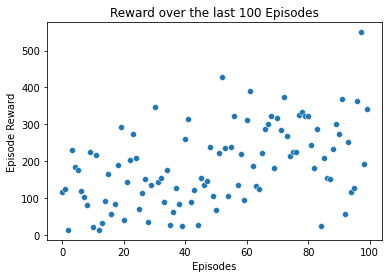

In [44]:
plot_rewards(results3a)

### Option 3b: Use LSTM for Processing the Sequence

Again max sequence length 10

Also see the corresponding RLlib example: https://github.com/ray-project/ray/blob/master/rllib/examples/cartpole_lstm.py

In [45]:
config3b = ppo.DEFAULT_CONFIG.copy()
config3b["env"] = "StatelessCartPole"
config3b["model"] = {
    "use_lstm": True,
    "max_seq_len": 10,
}

results3b = ray.tune.run("PPO", config=config3b, stop=stop)
print("Option 3b: Training finished successfully")

Trial name,status,loc
PPO_StatelessCartPole_72c9b_00000,PENDING,


(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)


Trial name,status,loc
PPO_StatelessCartPole_72c9b_00000,PENDING,


(pid=8232) 2021-11-23 19:52:15,002	INFO trainer.py:753 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=8232) 2021-11-23 19:52:15,002	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(pid=8232) 2021-11-23 19:52:15,002	INFO trainer.py:770 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=20100) 2021-11-23 19:52:27,435	WARNING deprecation.py:38 -- Deprecati

Trial name,status,loc
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232


(pid=8232) 2021-11-23 19:52:32,885	WARNING trainer_template.py:185 -- `execution_plan` functions should accept `trainer`, `workers`, and `config` as args!
(pid=8232) 2021-11-23 19:52:32,885	INFO trainable.py:110 -- Trainable.setup took 17.900 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(pid=8232) 2021-11-23 19:52:32,885	WARNING util.py:57 -- Install gputil for GPU system monitoring.


Trial name,status,loc
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232


(pid=8232) 2021-11-23 19:52:38,751	WARNING deprecation.py:38 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!


Trial name,status,loc
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232


Trial name,status,loc
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232


Trial name,status,loc
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232


Trial name,status,loc
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232


Trial name,status,loc
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232


Trial name,status,loc
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232


Trial name,status,loc
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232


Trial name,status,loc
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232


Trial name,status,loc
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232


Trial name,status,loc
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232


Result for PPO_StatelessCartPole_72c9b_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2021-11-23_19-53-30
  done: false
  episode_len_mean: 23.963636363636365
  episode_media: {}
  episode_reward_max: 73.0
  episode_reward_mean: 23.963636363636365
  episode_reward_min: 9.0
  episodes_this_iter: 165
  episodes_total: 165
  experiment_id: 5ab5d39a5646406282869656a0cafe8c
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.6856714487075806
          entropy_coeff: 0.0
          kl: 0.0071548279374837875
          model: {}
          policy_loss: -0.013108992949128151
          total_loss: 156.71572875976562
          vf_explained_var: -0.1254156082868576
          vf_loss: 156.72740173339844
    num_agent_steps_sampled: 4000
    num_agent_steps_trained: 4000
    num_steps_sampled: 4000
    num_steps_train

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,1,57.1004,4000,23.9636,73,9,23.9636


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,1,57.1004,4000,23.9636,73,9,23.9636


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,1,57.1004,4000,23.9636,73,9,23.9636


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,1,57.1004,4000,23.9636,73,9,23.9636


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,1,57.1004,4000,23.9636,73,9,23.9636


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,1,57.1004,4000,23.9636,73,9,23.9636


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,1,57.1004,4000,23.9636,73,9,23.9636


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,1,57.1004,4000,23.9636,73,9,23.9636


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,1,57.1004,4000,23.9636,73,9,23.9636


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,1,57.1004,4000,23.9636,73,9,23.9636


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,1,57.1004,4000,23.9636,73,9,23.9636


Result for PPO_StatelessCartPole_72c9b_00000:
  agent_timesteps_total: 8000
  custom_metrics: {}
  date: 2021-11-23_19-54-28
  done: false
  episode_len_mean: 25.468354430379748
  episode_media: {}
  episode_reward_max: 97.0
  episode_reward_mean: 25.468354430379748
  episode_reward_min: 10.0
  episodes_this_iter: 158
  episodes_total: 323
  experiment_id: 5ab5d39a5646406282869656a0cafe8c
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.6618409752845764
          entropy_coeff: 0.0
          kl: 0.01124719437211752
          model: {}
          policy_loss: -0.009560177102684975
          total_loss: 122.11344146728516
          vf_explained_var: 0.11272706091403961
          vf_loss: 122.1207504272461
    num_agent_steps_sampled: 8000
    num_agent_steps_trained: 8000
    num_steps_sampled: 8000
    num_steps_trained

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,2,115.167,8000,25.4684,97,10,25.4684


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,2,115.167,8000,25.4684,97,10,25.4684


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,2,115.167,8000,25.4684,97,10,25.4684


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,2,115.167,8000,25.4684,97,10,25.4684


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,2,115.167,8000,25.4684,97,10,25.4684


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,2,115.167,8000,25.4684,97,10,25.4684


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,2,115.167,8000,25.4684,97,10,25.4684


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,2,115.167,8000,25.4684,97,10,25.4684


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,2,115.167,8000,25.4684,97,10,25.4684


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,2,115.167,8000,25.4684,97,10,25.4684


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,2,115.167,8000,25.4684,97,10,25.4684


Result for PPO_StatelessCartPole_72c9b_00000:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2021-11-23_19-55-25
  done: false
  episode_len_mean: 32.08870967741935
  episode_media: {}
  episode_reward_max: 90.0
  episode_reward_mean: 32.08870967741935
  episode_reward_min: 9.0
  episodes_this_iter: 124
  episodes_total: 447
  experiment_id: 5ab5d39a5646406282869656a0cafe8c
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.6306056380271912
          entropy_coeff: 0.0
          kl: 0.009760460816323757
          model: {}
          policy_loss: -0.0017034645425155759
          total_loss: 144.0667724609375
          vf_explained_var: 0.15614184737205505
          vf_loss: 144.06649780273438
    num_agent_steps_sampled: 12000
    num_agent_steps_trained: 12000
    num_steps_sampled: 12000
    num_steps_trai

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,3,172.167,12000,32.0887,90,9,32.0887


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,3,172.167,12000,32.0887,90,9,32.0887


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,3,172.167,12000,32.0887,90,9,32.0887


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,3,172.167,12000,32.0887,90,9,32.0887


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,3,172.167,12000,32.0887,90,9,32.0887


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,3,172.167,12000,32.0887,90,9,32.0887


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,3,172.167,12000,32.0887,90,9,32.0887


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,3,172.167,12000,32.0887,90,9,32.0887


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,3,172.167,12000,32.0887,90,9,32.0887


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,3,172.167,12000,32.0887,90,9,32.0887


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,3,172.167,12000,32.0887,90,9,32.0887


Result for PPO_StatelessCartPole_72c9b_00000:
  agent_timesteps_total: 16000
  custom_metrics: {}
  date: 2021-11-23_19-56-20
  done: false
  episode_len_mean: 35.166666666666664
  episode_media: {}
  episode_reward_max: 88.0
  episode_reward_mean: 35.166666666666664
  episode_reward_min: 10.0
  episodes_this_iter: 114
  episodes_total: 561
  experiment_id: 5ab5d39a5646406282869656a0cafe8c
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.6015979647636414
          entropy_coeff: 0.0
          kl: 0.006288235541433096
          model: {}
          policy_loss: -0.002494542161002755
          total_loss: 122.13024139404297
          vf_explained_var: 0.2030862718820572
          vf_loss: 122.13147735595703
    num_agent_steps_sampled: 16000
    num_agent_steps_trained: 16000
    num_steps_sampled: 16000
    num_steps_tr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,4,227.684,16000,35.1667,88,10,35.1667


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,4,227.684,16000,35.1667,88,10,35.1667


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,4,227.684,16000,35.1667,88,10,35.1667


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,4,227.684,16000,35.1667,88,10,35.1667


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,4,227.684,16000,35.1667,88,10,35.1667


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,4,227.684,16000,35.1667,88,10,35.1667


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,4,227.684,16000,35.1667,88,10,35.1667


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,4,227.684,16000,35.1667,88,10,35.1667


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,4,227.684,16000,35.1667,88,10,35.1667


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,4,227.684,16000,35.1667,88,10,35.1667


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,4,227.684,16000,35.1667,88,10,35.1667


Result for PPO_StatelessCartPole_72c9b_00000:
  agent_timesteps_total: 20000
  custom_metrics: {}
  date: 2021-11-23_19-57-16
  done: false
  episode_len_mean: 35.60176991150443
  episode_media: {}
  episode_reward_max: 82.0
  episode_reward_mean: 35.60176991150443
  episode_reward_min: 9.0
  episodes_this_iter: 113
  episodes_total: 674
  experiment_id: 5ab5d39a5646406282869656a0cafe8c
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.592738926410675
          entropy_coeff: 0.0
          kl: 0.010486969724297523
          model: {}
          policy_loss: -0.002916128607466817
          total_loss: 138.9017333984375
          vf_explained_var: 0.2189464569091797
          vf_loss: 138.90255737304688
    num_agent_steps_sampled: 20000
    num_agent_steps_trained: 20000
    num_steps_sampled: 20000
    num_steps_trained

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,5,283.947,20000,35.6018,82,9,35.6018


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,5,283.947,20000,35.6018,82,9,35.6018


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,5,283.947,20000,35.6018,82,9,35.6018


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,5,283.947,20000,35.6018,82,9,35.6018


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,5,283.947,20000,35.6018,82,9,35.6018


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,5,283.947,20000,35.6018,82,9,35.6018


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,5,283.947,20000,35.6018,82,9,35.6018


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,5,283.947,20000,35.6018,82,9,35.6018


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,5,283.947,20000,35.6018,82,9,35.6018


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,5,283.947,20000,35.6018,82,9,35.6018


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,5,283.947,20000,35.6018,82,9,35.6018


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,5,283.947,20000,35.6018,82,9,35.6018


Result for PPO_StatelessCartPole_72c9b_00000:
  agent_timesteps_total: 24000
  custom_metrics: {}
  date: 2021-11-23_19-58-19
  done: false
  episode_len_mean: 33.36974789915966
  episode_media: {}
  episode_reward_max: 91.0
  episode_reward_mean: 33.36974789915966
  episode_reward_min: 10.0
  episodes_this_iter: 119
  episodes_total: 793
  experiment_id: 5ab5d39a5646406282869656a0cafe8c
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.600585401058197
          entropy_coeff: 0.0
          kl: 0.007351159583777189
          model: {}
          policy_loss: -0.0014522389974445105
          total_loss: 115.78807067871094
          vf_explained_var: 0.24461466073989868
          vf_loss: 115.7880630493164
    num_agent_steps_sampled: 24000
    num_agent_steps_trained: 24000
    num_steps_sampled: 24000
    num_steps_trai

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,6,346.413,24000,33.3697,91,10,33.3697


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,6,346.413,24000,33.3697,91,10,33.3697


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,6,346.413,24000,33.3697,91,10,33.3697


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,6,346.413,24000,33.3697,91,10,33.3697


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,6,346.413,24000,33.3697,91,10,33.3697


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,6,346.413,24000,33.3697,91,10,33.3697


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,6,346.413,24000,33.3697,91,10,33.3697


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,6,346.413,24000,33.3697,91,10,33.3697


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,6,346.413,24000,33.3697,91,10,33.3697


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,6,346.413,24000,33.3697,91,10,33.3697


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,6,346.413,24000,33.3697,91,10,33.3697


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,6,346.413,24000,33.3697,91,10,33.3697


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,6,346.413,24000,33.3697,91,10,33.3697


Result for PPO_StatelessCartPole_72c9b_00000:
  agent_timesteps_total: 28000
  custom_metrics: {}
  date: 2021-11-23_19-59-29
  done: false
  episode_len_mean: 34.61739130434783
  episode_media: {}
  episode_reward_max: 87.0
  episode_reward_mean: 34.61739130434783
  episode_reward_min: 9.0
  episodes_this_iter: 115
  episodes_total: 908
  experiment_id: 5ab5d39a5646406282869656a0cafe8c
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.5933268666267395
          entropy_coeff: 0.0
          kl: 0.009403372183442116
          model: {}
          policy_loss: 0.0012451679212972522
          total_loss: 112.21086883544922
          vf_explained_var: 0.2490883767604828
          vf_loss: 112.20774841308594
    num_agent_steps_sampled: 28000
    num_agent_steps_trained: 28000
    num_steps_sampled: 28000
    num_steps_train

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,7,416.19,28000,34.6174,87,9,34.6174


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,7,416.19,28000,34.6174,87,9,34.6174


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,7,416.19,28000,34.6174,87,9,34.6174


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,7,416.19,28000,34.6174,87,9,34.6174


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,7,416.19,28000,34.6174,87,9,34.6174


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,7,416.19,28000,34.6174,87,9,34.6174


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,7,416.19,28000,34.6174,87,9,34.6174


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,7,416.19,28000,34.6174,87,9,34.6174


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,7,416.19,28000,34.6174,87,9,34.6174


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,7,416.19,28000,34.6174,87,9,34.6174


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,7,416.19,28000,34.6174,87,9,34.6174


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,7,416.19,28000,34.6174,87,9,34.6174


Result for PPO_StatelessCartPole_72c9b_00000:
  agent_timesteps_total: 32000
  custom_metrics: {}
  date: 2021-11-23_20-00-34
  done: false
  episode_len_mean: 33.87394957983193
  episode_media: {}
  episode_reward_max: 101.0
  episode_reward_mean: 33.87394957983193
  episode_reward_min: 9.0
  episodes_this_iter: 119
  episodes_total: 1027
  experiment_id: 5ab5d39a5646406282869656a0cafe8c
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.5909730792045593
          entropy_coeff: 0.0
          kl: 0.010507854633033276
          model: {}
          policy_loss: -0.007771820295602083
          total_loss: 125.65485382080078
          vf_explained_var: 0.306622177362442
          vf_loss: 125.66051483154297
    num_agent_steps_sampled: 32000
    num_agent_steps_trained: 32000
    num_steps_sampled: 32000
    num_steps_trai

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,8,481.359,32000,33.8739,101,9,33.8739


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,8,481.359,32000,33.8739,101,9,33.8739


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,8,481.359,32000,33.8739,101,9,33.8739


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,8,481.359,32000,33.8739,101,9,33.8739


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,8,481.359,32000,33.8739,101,9,33.8739


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,8,481.359,32000,33.8739,101,9,33.8739


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,8,481.359,32000,33.8739,101,9,33.8739


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,8,481.359,32000,33.8739,101,9,33.8739


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,8,481.359,32000,33.8739,101,9,33.8739


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,8,481.359,32000,33.8739,101,9,33.8739


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,8,481.359,32000,33.8739,101,9,33.8739


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,8,481.359,32000,33.8739,101,9,33.8739


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,8,481.359,32000,33.8739,101,9,33.8739


Result for PPO_StatelessCartPole_72c9b_00000:
  agent_timesteps_total: 36000
  custom_metrics: {}
  date: 2021-11-23_20-01-40
  done: false
  episode_len_mean: 38.625
  episode_media: {}
  episode_reward_max: 99.0
  episode_reward_mean: 38.625
  episode_reward_min: 11.0
  episodes_this_iter: 104
  episodes_total: 1131
  experiment_id: 5ab5d39a5646406282869656a0cafe8c
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.5758077502250671
          entropy_coeff: 0.0
          kl: 0.008066794835031033
          model: {}
          policy_loss: -0.00612681033089757
          total_loss: 112.96802520751953
          vf_explained_var: 0.3204708695411682
          vf_loss: 112.97254943847656
    num_agent_steps_sampled: 36000
    num_agent_steps_trained: 36000
    num_steps_sampled: 36000
    num_steps_trained: 36000
    num_ste

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,9,547.355,36000,38.625,99,11,38.625


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,9,547.355,36000,38.625,99,11,38.625


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,9,547.355,36000,38.625,99,11,38.625


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,9,547.355,36000,38.625,99,11,38.625


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,9,547.355,36000,38.625,99,11,38.625


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,9,547.355,36000,38.625,99,11,38.625


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,9,547.355,36000,38.625,99,11,38.625


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,9,547.355,36000,38.625,99,11,38.625


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,9,547.355,36000,38.625,99,11,38.625


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,9,547.355,36000,38.625,99,11,38.625


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,RUNNING,127.0.0.1:8232,9,547.355,36000,38.625,99,11,38.625


Result for PPO_StatelessCartPole_72c9b_00000:
  agent_timesteps_total: 40000
  custom_metrics: {}
  date: 2021-11-23_20-02-37
  done: true
  episode_len_mean: 34.721739130434784
  episode_media: {}
  episode_reward_max: 142.0
  episode_reward_mean: 34.721739130434784
  episode_reward_min: 9.0
  episodes_this_iter: 115
  episodes_total: 1246
  experiment_id: 5ab5d39a5646406282869656a0cafe8c
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.5509825348854065
          entropy_coeff: 0.0
          kl: 0.009169220924377441
          model: {}
          policy_loss: -0.011567086912691593
          total_loss: 137.02117919921875
          vf_explained_var: 0.3223947286605835
          vf_loss: 137.03091430664062
    num_agent_steps_sampled: 40000
    num_agent_steps_trained: 40000
    num_steps_sampled: 40000
    num_steps_tr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,TERMINATED,127.0.0.1:8232,10,604.54,40000,34.7217,142,9,34.7217


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_72c9b_00000,TERMINATED,127.0.0.1:8232,10,604.54,40000,34.7217,142,9,34.7217


(pid=8232) [2021-11-23 20:02:38,188 E 8232 580] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
(pid=8232) Windows fatal exception: access violation
(pid=8232) 
(pid=20100) [2021-11-23 20:02:38,195 E 20100 5616] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
(pid=20100) Windows fatal exception: access violation
(pid=20100) 
(pid=1604) [2021-11-23 20:02:38,210 C 1604 16564] core_worker.cc:796:  Check failed: _s.ok() Bad status: IOError: Unknown error
(pid=1604) *** StackTrace Information ***
(pid=1604)     PyInit__raylet
(pid=1604)     PyInit__raylet
(pid=1604)     PyInit__raylet
(pid=1604)     PyInit__raylet
(pid=1604)     PyInit__raylet
(pid=1604)     PyInit__raylet
(pid=1604)     PyInit__raylet
(pid=1604)     PyInit__raylet
(pid=1604)     PyInit__raylet
(pid=1604)     PyInit__raylet
(pid=1604)     PyInit__raylet
(pid=1604)     PyInit__raylet
(pid=1604)     PyInit__raylet
(pid=1604)     PyInit

Option 3b: Training finished successfully


In [46]:
# check results
results3b.default_metric = "episode_reward_mean"
results3b.default_mode = "max"
# print the mean episode reward = episode length --> higher = better
results3b.best_result["episode_reward_mean"]

34.721739130434784

c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


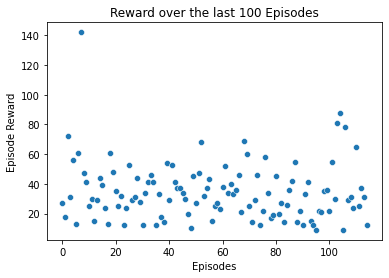

In [47]:
plot_rewards(results3b)

### Option 3c: Use Attention for Processing the Sequence

TODO: continue here
https://github.com/ray-project/ray/blob/master/rllib/examples/attention_net.py

> Tip: Also check out the [RLlib example using AttentionNet](https://github.com/ray-project/ray/blob/master/rllib/examples/attention_net.py).


In [48]:
config3c = ppo.DEFAULT_CONFIG.copy()
config3c["env"] = "StatelessCartPole"
config3c["model"] = {
    # Attention net wrapping (for tf) can already use the native keras
    # model versions. For torch, this will have no effect.
    "_use_default_native_models": True,
    "use_attention": True,
    "max_seq_len": 10,
    "attention_num_transformer_units": 1,
    "attention_dim": 32,
    "attention_memory_inference": 10,
    "attention_memory_training": 10,
    "attention_num_heads": 1,
    "attention_head_dim": 32,
    "attention_position_wise_mlp_dim": 32,
}

results3c = ray.tune.run("PPO", config=config3c, stop=stop)
print("Option 3c: Training finished successfully")

Trial name,status,loc
PPO_StatelessCartPole_ed349_00000,PENDING,


(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)


Trial name,status,loc
PPO_StatelessCartPole_ed349_00000,PENDING,


(pid=20568) 2021-11-23 20:02:50,120	INFO trainer.py:753 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=20568) 2021-11-23 20:02:50,120	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(pid=20568) 2021-11-23 20:02:50,120	INFO trainer.py:770 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)


Trial name,status,loc
PPO_StatelessCartPole_ed349_00000,RUNNING,127.0.0.1:20568


(pid=20568) 2021-11-23 20:03:15,691	WARNING trainer_template.py:185 -- `execution_plan` functions should accept `trainer`, `workers`, and `config` as args!
(pid=20568) 2021-11-23 20:03:15,691	INFO trainable.py:110 -- Trainable.setup took 25.571 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(pid=20568) 2021-11-23 20:03:15,707	WARNING util.py:57 -- Install gputil for GPU system monitoring.


Trial name,status,loc
PPO_StatelessCartPole_ed349_00000,RUNNING,127.0.0.1:20568


Trial name,status,loc
PPO_StatelessCartPole_ed349_00000,RUNNING,127.0.0.1:20568


(pid=20568) 2021-11-23 20:03:22,282	WARNING deprecation.py:38 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!


Trial name,status,loc
PPO_StatelessCartPole_ed349_00000,RUNNING,127.0.0.1:20568


Trial name,status,loc
PPO_StatelessCartPole_ed349_00000,RUNNING,127.0.0.1:20568


Result for PPO_StatelessCartPole_ed349_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2021-11-23_20-03-32
  done: false
  episode_len_mean: 21.262032085561497
  episode_media: {}
  episode_reward_max: 81.0
  episode_reward_mean: 21.262032085561497
  episode_reward_min: 9.0
  episodes_this_iter: 187
  episodes_total: 187
  experiment_id: a20dca4fd94f46728886d8f17aa6afef
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.679179847240448
          entropy_coeff: 0.0
          kl: 0.010041364468634129
          policy_loss: -0.0052756150253117085
          total_loss: 135.094482421875
          vf_explained_var: 0.0008982037543319166
          vf_loss: 135.09776306152344
    num_agent_steps_sampled: 4000
    num_agent_steps_trained: 4000
    num_steps_sampled: 4000
    num_steps_trained: 4000
  iterations

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_ed349_00000,RUNNING,127.0.0.1:20568,1,16.8119,4000,21.262,81,9,21.262


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_ed349_00000,RUNNING,127.0.0.1:20568,1,16.8119,4000,21.262,81,9,21.262


Result for PPO_StatelessCartPole_ed349_00000:
  agent_timesteps_total: 8000
  custom_metrics: {}
  date: 2021-11-23_20-03-47
  done: false
  episode_len_mean: 24.08433734939759
  episode_media: {}
  episode_reward_max: 82.0
  episode_reward_mean: 24.08433734939759
  episode_reward_min: 9.0
  episodes_this_iter: 166
  episodes_total: 353
  experiment_id: a20dca4fd94f46728886d8f17aa6afef
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.6655676960945129
          entropy_coeff: 0.0
          kl: 0.029991917312145233
          policy_loss: -0.008723784238100052
          total_loss: 85.6485366821289
          vf_explained_var: 0.015965590253472328
          vf_loss: 85.65127563476562
    num_agent_steps_sampled: 8000
    num_agent_steps_trained: 8000
    num_steps_sampled: 8000
    num_steps_trained: 8000
    num_steps_tr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_ed349_00000,RUNNING,127.0.0.1:20568,2,31.7467,8000,24.0843,82,9,24.0843


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_ed349_00000,RUNNING,127.0.0.1:20568,2,31.7467,8000,24.0843,82,9,24.0843


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_ed349_00000,RUNNING,127.0.0.1:20568,2,31.7467,8000,24.0843,82,9,24.0843


Result for PPO_StatelessCartPole_ed349_00000:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2021-11-23_20-04-02
  done: false
  episode_len_mean: 32.60655737704918
  episode_media: {}
  episode_reward_max: 97.0
  episode_reward_mean: 32.60655737704918
  episode_reward_min: 9.0
  episodes_this_iter: 122
  episodes_total: 475
  experiment_id: a20dca4fd94f46728886d8f17aa6afef
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.30000001192092896
          cur_lr: 4.999999873689376e-05
          entropy: 0.6112883687019348
          entropy_coeff: 0.0
          kl: 0.015228519216179848
          policy_loss: 0.006799531634896994
          total_loss: 151.49966430664062
          vf_explained_var: -0.026928376406431198
          vf_loss: 151.48826599121094
    num_agent_steps_sampled: 12000
    num_agent_steps_trained: 12000
    num_steps_sampled: 12000
    num_steps_trained: 12000
    num_

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_ed349_00000,RUNNING,127.0.0.1:20568,3,47.1871,12000,32.6066,97,9,32.6066


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_ed349_00000,RUNNING,127.0.0.1:20568,3,47.1871,12000,32.6066,97,9,32.6066


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_ed349_00000,RUNNING,127.0.0.1:20568,3,47.1871,12000,32.6066,97,9,32.6066


Result for PPO_StatelessCartPole_ed349_00000:
  agent_timesteps_total: 16000
  custom_metrics: {}
  date: 2021-11-23_20-04-17
  done: false
  episode_len_mean: 31.936507936507937
  episode_media: {}
  episode_reward_max: 127.0
  episode_reward_mean: 31.936507936507937
  episode_reward_min: 10.0
  episodes_this_iter: 126
  episodes_total: 601
  experiment_id: a20dca4fd94f46728886d8f17aa6afef
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.30000001192092896
          cur_lr: 4.999999873689376e-05
          entropy: 0.5917171835899353
          entropy_coeff: 0.0
          kl: 0.007773145567625761
          policy_loss: -0.01154142152518034
          total_loss: 164.59902954101562
          vf_explained_var: -0.02803165465593338
          vf_loss: 164.60824584960938
    num_agent_steps_sampled: 16000
    num_agent_steps_trained: 16000
    num_steps_sampled: 16000
    num_steps_trained: 16000
    n

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_ed349_00000,RUNNING,127.0.0.1:20568,4,61.9234,16000,31.9365,127,10,31.9365


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_ed349_00000,RUNNING,127.0.0.1:20568,4,61.9234,16000,31.9365,127,10,31.9365


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_ed349_00000,RUNNING,127.0.0.1:20568,4,61.9234,16000,31.9365,127,10,31.9365


Result for PPO_StatelessCartPole_ed349_00000:
  agent_timesteps_total: 20000
  custom_metrics: {}
  date: 2021-11-23_20-04-33
  done: false
  episode_len_mean: 36.18348623853211
  episode_media: {}
  episode_reward_max: 169.0
  episode_reward_mean: 36.18348623853211
  episode_reward_min: 11.0
  episodes_this_iter: 109
  episodes_total: 710
  experiment_id: a20dca4fd94f46728886d8f17aa6afef
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.30000001192092896
          cur_lr: 4.999999873689376e-05
          entropy: 0.5868048667907715
          entropy_coeff: 0.0
          kl: 0.011738005094230175
          policy_loss: -0.0034831564407795668
          total_loss: 237.54965209960938
          vf_explained_var: -0.013120776042342186
          vf_loss: 237.5496063232422
    num_agent_steps_sampled: 20000
    num_agent_steps_trained: 20000
    num_steps_sampled: 20000
    num_steps_trained: 20000
    n

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_ed349_00000,RUNNING,127.0.0.1:20568,5,77.7423,20000,36.1835,169,11,36.1835


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_ed349_00000,RUNNING,127.0.0.1:20568,5,77.7423,20000,36.1835,169,11,36.1835


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_ed349_00000,RUNNING,127.0.0.1:20568,5,77.7423,20000,36.1835,169,11,36.1835


Result for PPO_StatelessCartPole_ed349_00000:
  agent_timesteps_total: 24000
  custom_metrics: {}
  date: 2021-11-23_20-04-48
  done: false
  episode_len_mean: 41.74
  episode_media: {}
  episode_reward_max: 136.0
  episode_reward_mean: 41.74
  episode_reward_min: 10.0
  episodes_this_iter: 94
  episodes_total: 804
  experiment_id: a20dca4fd94f46728886d8f17aa6afef
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.30000001192092896
          cur_lr: 4.999999873689376e-05
          entropy: 0.5268979072570801
          entropy_coeff: 0.0
          kl: 0.007060217205435038
          policy_loss: -0.001066685770638287
          total_loss: 199.92935180664062
          vf_explained_var: 0.024954820051789284
          vf_loss: 199.9282989501953
    num_agent_steps_sampled: 24000
    num_agent_steps_trained: 24000
    num_steps_sampled: 24000
    num_steps_trained: 24000
    num_steps_trained_this_iter:

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_ed349_00000,RUNNING,127.0.0.1:20568,6,93.0083,24000,41.74,136,10,41.74


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_ed349_00000,RUNNING,127.0.0.1:20568,6,93.0083,24000,41.74,136,10,41.74


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_ed349_00000,RUNNING,127.0.0.1:20568,6,93.0083,24000,41.74,136,10,41.74


Result for PPO_StatelessCartPole_ed349_00000:
  agent_timesteps_total: 28000
  custom_metrics: {}
  date: 2021-11-23_20-05-05
  done: false
  episode_len_mean: 42.5
  episode_media: {}
  episode_reward_max: 125.0
  episode_reward_mean: 42.5
  episode_reward_min: 10.0
  episodes_this_iter: 94
  episodes_total: 898
  experiment_id: a20dca4fd94f46728886d8f17aa6afef
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.30000001192092896
          cur_lr: 4.999999873689376e-05
          entropy: 0.5345466732978821
          entropy_coeff: 0.0
          kl: 0.007870975881814957
          policy_loss: -0.01049668900668621
          total_loss: 195.44029235839844
          vf_explained_var: -0.021700987592339516
          vf_loss: 195.44842529296875
    num_agent_steps_sampled: 28000
    num_agent_steps_trained: 28000
    num_steps_sampled: 28000
    num_steps_trained: 28000
    num_steps_trained_this_iter: 

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_ed349_00000,RUNNING,127.0.0.1:20568,7,109.408,28000,42.5,125,10,42.5


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_ed349_00000,RUNNING,127.0.0.1:20568,7,109.408,28000,42.5,125,10,42.5


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_ed349_00000,RUNNING,127.0.0.1:20568,7,109.408,28000,42.5,125,10,42.5


Result for PPO_StatelessCartPole_ed349_00000:
  agent_timesteps_total: 32000
  custom_metrics: {}
  date: 2021-11-23_20-05-20
  done: false
  episode_len_mean: 51.26
  episode_media: {}
  episode_reward_max: 212.0
  episode_reward_mean: 51.26
  episode_reward_min: 10.0
  episodes_this_iter: 73
  episodes_total: 971
  experiment_id: a20dca4fd94f46728886d8f17aa6afef
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.30000001192092896
          cur_lr: 4.999999873689376e-05
          entropy: 0.5582462549209595
          entropy_coeff: 0.0
          kl: 0.01066754013299942
          policy_loss: 0.013204912655055523
          total_loss: 302.75701904296875
          vf_explained_var: -0.020273517817258835
          vf_loss: 302.7406005859375
    num_agent_steps_sampled: 32000
    num_agent_steps_trained: 32000
    num_steps_sampled: 32000
    num_steps_trained: 32000
    num_steps_trained_this_iter: 

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_ed349_00000,RUNNING,127.0.0.1:20568,8,124.456,32000,51.26,212,10,51.26


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_ed349_00000,RUNNING,127.0.0.1:20568,8,124.456,32000,51.26,212,10,51.26


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_ed349_00000,RUNNING,127.0.0.1:20568,8,124.456,32000,51.26,212,10,51.26


Result for PPO_StatelessCartPole_ed349_00000:
  agent_timesteps_total: 36000
  custom_metrics: {}
  date: 2021-11-23_20-05-35
  done: false
  episode_len_mean: 42.09
  episode_media: {}
  episode_reward_max: 153.0
  episode_reward_mean: 42.09
  episode_reward_min: 10.0
  episodes_this_iter: 96
  episodes_total: 1067
  experiment_id: a20dca4fd94f46728886d8f17aa6afef
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.30000001192092896
          cur_lr: 4.999999873689376e-05
          entropy: 0.503809928894043
          entropy_coeff: 0.0
          kl: 0.011404866352677345
          policy_loss: -0.005207857117056847
          total_loss: 224.0603790283203
          vf_explained_var: 0.009964415803551674
          vf_loss: 224.06216430664062
    num_agent_steps_sampled: 36000
    num_agent_steps_trained: 36000
    num_steps_sampled: 36000
    num_steps_trained: 36000
    num_steps_trained_this_iter:

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_ed349_00000,RUNNING,127.0.0.1:20568,9,139.174,36000,42.09,153,10,42.09


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_ed349_00000,RUNNING,127.0.0.1:20568,9,139.174,36000,42.09,153,10,42.09


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_ed349_00000,RUNNING,127.0.0.1:20568,9,139.174,36000,42.09,153,10,42.09


Result for PPO_StatelessCartPole_ed349_00000:
  agent_timesteps_total: 40000
  custom_metrics: {}
  date: 2021-11-23_20-05-49
  done: true
  episode_len_mean: 53.41
  episode_media: {}
  episode_reward_max: 216.0
  episode_reward_mean: 53.41
  episode_reward_min: 10.0
  episodes_this_iter: 68
  episodes_total: 1135
  experiment_id: a20dca4fd94f46728886d8f17aa6afef
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.30000001192092896
          cur_lr: 4.999999873689376e-05
          entropy: 0.4461559057235718
          entropy_coeff: 0.0
          kl: 0.006264682859182358
          policy_loss: 0.0033616276923567057
          total_loss: 333.1831359863281
          vf_explained_var: -0.007664728909730911
          vf_loss: 333.17791748046875
    num_agent_steps_sampled: 40000
    num_agent_steps_trained: 40000
    num_steps_sampled: 40000
    num_steps_trained: 40000
    num_steps_trained_this_iter

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_ed349_00000,TERMINATED,127.0.0.1:20568,10,153.807,40000,53.41,216,10,53.41


(pid=20568) Windows fatal exception: access violation
(pid=20568) 
(pid=17696) [2021-11-23 20:05:50,166 E 17696 2012] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
(pid=17696) Windows fatal exception: access violation
(pid=17696) 
(pid=9728) [2021-11-23 20:05:50,165 E 9728 18184] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
(pid=9728) Windows fatal exception: access violation
(pid=9728) 
2021-11-23 20:05:50,279	INFO tune.py:630 -- Total run time: 191.75 seconds (191.40 seconds for the tuning loop).


Option 3c: Training finished successfully


In [49]:
# check results
results3c.default_metric = "episode_reward_mean"
results3c.default_mode = "max"
# print the mean episode reward = episode length --> higher = better
results3c.best_result["episode_reward_mean"]

53.41

c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


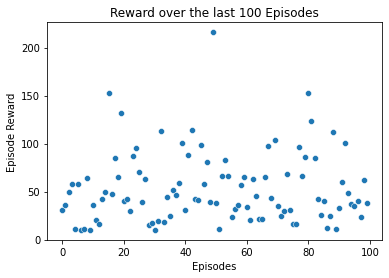

In [50]:
plot_rewards(results3c)